#  Build a Large Language Model (LLM) from Scratch


---
#  Chapter 0: Setup and Environment

Before we start building, let's set up our environment.

In [ ]:
# Import all necessary libraries
import torch  # PyTorch: our deep learning framework
import torch.nn as nn  # Neural network modules
import torch.nn.functional as F  # Functional operations (activations, etc.)
from torch.utils.data import Dataset, DataLoader  # Data loading utilities
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Plotting and visualization
import math  # Mathematical operations
from tqdm import tqdm  # Progress bars
import re  # Regular expressions for text processing

# Check if GPU is available - purtroppo no nel mio caso, si va di big cpu e ram :D 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Environment ready!")

Using device: cpu
PyTorch version: 2.9.1+cu128
Environment ready!


---
#  Chapter 1: Tokenization

##  Theory

**What is Tokenization?**

Tokenization is the process of converting text into numbers that a neural network can understand.

**Why do we need it?**
- Neural networks work with numbers, not text
- We need a systematic way to convert "Hello world" → [15496, 995]
- Must be reversible: [15496, 995] → "Hello world"

**Types of Tokenization:**

1. **Character-level**: Each character is a token
   - "Hello" → ['H', 'e', 'l', 'l', 'o']

2. **Word-level**: Each word is a token
   - "Hello world" → ['Hello', 'world']

3. **Subword-level** (BPE, WordPiece): Best of both worlds
   - "tokenization" → ['token', 'ization']


##  Mathematics

For a vocabulary of size V, each token is mapped to an integer:

```
tokenize: text → [token_1, token_2, ..., token_n]
where each token_i ∈ {0, 1, 2, ..., V-1}
```

Example with V=50257 (GPT-2 vocabulary):
- "Hello" → [15496]
- "world" → [995]
- "Hello world" → [15496, 995]

##  Implementation

Let's build a simple character-level tokenizer first to understand the concept:

In [3]:
class SimpleCharTokenizer:
    """
    A simple character-level tokenizer for educational purposes.
    
    This tokenizer:
    1. Builds a vocabulary from all unique characters in the text
    2. Maps each character to a unique integer ID
    3. Can encode text to IDs and decode IDs back to text
    """
    
    def __init__(self):
        # char2idx: dictionary mapping characters to integer IDs
        self.char2idx = {}
        # idx2char: dictionary mapping integer IDs back to characters
        self.idx2char = {}
        # vocab_size: total number of unique characters
        self.vocab_size = 0
    
    def build_vocabulary(self, text):
        """
        Build vocabulary from text.
        
        Args:
            text (str): Input text to build vocabulary from
        """
        # Get all unique characters in the text and sort them
        # Sorting ensures consistent ordering
        unique_chars = sorted(set(text))
        
        # Enumerate creates (index, char) pairs starting from 0
        for idx, char in enumerate(unique_chars):
            self.char2idx[char] = idx  # Map character to index
            self.idx2char[idx] = char  # Map index back to character
        
        # Store vocabulary size for easy access
        self.vocab_size = len(unique_chars)
        
        print(f"Vocabulary built: {self.vocab_size} unique characters")
        print(f"Sample mappings: {dict(list(self.char2idx.items())[:10])}")
    
    def encode(self, text):
        """
        Convert text to list of token IDs.
        
        Args:
            text (str): Text to encode
            
        Returns:
            list: List of integer token IDs
        """
        # For each character in text, look up its ID in char2idx
        # get(char, 0) returns 0 if character is not in vocabulary
        return [self.char2idx.get(char, 0) for char in text]
    
    def decode(self, ids):
        """
        Convert list of token IDs back to text.
        
        Args:
            ids (list): List of integer token IDs
            
        Returns:
            str: Decoded text
        """
        # For each ID, look up its character in idx2char
        # get(id, '?') returns '?' if ID is not in vocabulary
        return ''.join([self.idx2char.get(id, '?') for id in ids])


# Example: Let's test our tokenizer
print("=" * 60)
print("CHARACTER-LEVEL TOKENIZATION EXAMPLE")
print("=" * 60)

# Sample text
sample_text = "Hello, World! This is a simple tokenizer."

# Create and train tokenizer
tokenizer = SimpleCharTokenizer()
tokenizer.build_vocabulary(sample_text)

# Encode text to IDs
encoded = tokenizer.encode(sample_text)
print(f"\nOriginal text: {sample_text}")
print(f"Encoded (first 20 tokens): {encoded[:20]}")

# Decode IDs back to text
decoded = tokenizer.decode(encoded)
print(f"Decoded text: {decoded}")
print(f"Match: {sample_text == decoded}")

CHARACTER-LEVEL TOKENIZATION EXAMPLE
Vocabulary built: 22 unique characters
Sample mappings: {' ': 0, '!': 1, ',': 2, '.': 3, 'H': 4, 'T': 5, 'W': 6, 'a': 7, 'd': 8, 'e': 9}

Original text: Hello, World! This is a simple tokenizer.
Encoded (first 20 tokens): [4, 9, 13, 13, 16, 2, 0, 6, 16, 18, 13, 8, 1, 0, 5, 10, 11, 19, 0, 11]
Decoded text: Hello, World! This is a simple tokenizer.
Match: True


###  GPT-2 Tokenizer

For real LLMs, we use more sophisticated tokenizers like GPT-2's BPE tokenizer:

In [4]:
# Try to import tiktoken (GPT-2 tokenizer)
# If not available, we'll use our simple tokenizer
try:
    import tiktoken
    
    # Get GPT-2 tokenizer
    gpt2_tokenizer = tiktoken.get_encoding("gpt2")
    
    # Test it
    text = "Hello, World! Let's tokenize this text."
    tokens = gpt2_tokenizer.encode(text)
    decoded = gpt2_tokenizer.decode(tokens)
    
    print("\n" + "=" * 60)
    print("GPT-2 TOKENIZATION EXAMPLE")
    print("=" * 60)
    print(f"Original: {text}")
    print(f"Tokens: {tokens}")
    print(f"Decoded: {decoded}")
    print(f"Vocabulary size: ~50,000 tokens")
    
    # Show how subword tokenization works
    word = "tokenization"
    word_tokens = gpt2_tokenizer.encode(word)
    print(f"\nSubword example: '{word}' →")
    for token_id in word_tokens:
        token_str = gpt2_tokenizer.decode([token_id])
        print(f"  [{token_id}] = '{token_str}'")
    
    USE_GPT2_TOKENIZER = True
    
except ImportError:
    print("\ntiktoken not available, using simple tokenizer")
    USE_GPT2_TOKENIZER = False
    gpt2_tokenizer = None


GPT-2 TOKENIZATION EXAMPLE
Original: Hello, World! Let's tokenize this text.
Tokens: [15496, 11, 2159, 0, 3914, 338, 11241, 1096, 428, 2420, 13]
Decoded: Hello, World! Let's tokenize this text.
Vocabulary size: ~50,000 tokens

Subword example: 'tokenization' →
  [30001] = 'token'
  [1634] = 'ization'


---
#  Chapter 2: Embeddings

##  Theory

**What are Embeddings?**

Embeddings convert discrete tokens (integers) into continuous vectors that capture semantic meaning.

**Why embeddings?**
- Token IDs are just numbers: 15496, 995
- No semantic relationship: ID 15496 isn't "close" to 15497 in meaning
- Embeddings place similar words close in vector space:
  - "king" and "queen" → similar vectors
  - "king" and "pizza" → different vectors

**Types of Embeddings in GPT:**

1. **Token Embeddings**: Encode word meaning
2. **Positional Embeddings**: Encode word position in sequence

##  Mathematics

**Token Embedding**:
```
E_token: {0, 1, ..., V-1} → ℝ^d

For token ID i:
e_i = E_token[i] ∈ ℝ^d
```

Where:
- V = vocabulary size (e.g., 50257)
- d = embedding dimension (e.g., 768)

**Positional Embedding**:
```
E_pos: {0, 1, ..., L-1} → ℝ^d

For position j:
p_j = E_pos[j] ∈ ℝ^d
```

Where L = max sequence length (e.g., 1024)

**Final Embedding**:
```
x_j = e_(token_j) + p_j
```

##  Implementation

In [5]:
class TokenEmbedding(nn.Module):
    """
    Token Embedding Layer.
    
    Converts token IDs to dense vector representations.
    This is essentially a lookup table where each token ID
    corresponds to a learnable vector.
    """
    
    def __init__(self, vocab_size, embed_dim):
        """
        Initialize token embedding.
        
        Args:
            vocab_size (int): Size of vocabulary (number of unique tokens)
            embed_dim (int): Dimension of embedding vectors
        """
        super().__init__()
        
        # Create embedding matrix of shape (vocab_size, embed_dim)
        # nn.Embedding is a simple lookup table that stores embeddings
        # of a fixed dictionary and size.
        # 
        # Example with vocab_size=10, embed_dim=4:
        # token_embedding.weight = tensor of shape (10, 4)
        # token_embedding(torch.tensor([0, 5, 3])) returns shape (3, 4)
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        
        self.embed_dim = embed_dim
    
    def forward(self, token_ids):
        """
        Convert token IDs to embeddings.
        
        Args:
            token_ids: Tensor of shape (batch_size, seq_len)
                      containing token IDs
        
        Returns:
            Tensor of shape (batch_size, seq_len, embed_dim)
            containing token embeddings
        """
        # Simply look up embeddings for each token ID
        # Input: (batch_size, seq_len) - integers
        # Output: (batch_size, seq_len, embed_dim) - floats
        return self.token_embedding(token_ids)


class PositionalEmbedding(nn.Module):
    """
    Positional Embedding Layer.
    
    Adds position information to token embeddings.
    Since transformers have no inherent notion of order,
    we must explicitly encode position information.
    """
    
    def __init__(self, max_seq_len, embed_dim):
        """
        Initialize positional embedding.
        
        Args:
            max_seq_len (int): Maximum sequence length
            embed_dim (int): Dimension of embedding vectors
        """
        super().__init__()
        
        # Create positional embedding matrix
        # Shape: (max_seq_len, embed_dim)
        # Each position gets its own learnable vector
        self.pos_embedding = nn.Embedding(max_seq_len, embed_dim)
        
        self.max_seq_len = max_seq_len
    
    def forward(self, token_embeddings):
        """
        Add positional embeddings to token embeddings.
        
        Args:
            token_embeddings: Tensor of shape (batch_size, seq_len, embed_dim)
        
        Returns:
            Tensor of same shape with positional information added
        """
        batch_size, seq_len, embed_dim = token_embeddings.shape
        
        # Create position indices: [0, 1, 2, ..., seq_len-1]
        # These are the same for all samples in the batch
        positions = torch.arange(seq_len, device=token_embeddings.device)
        
        # Look up positional embeddings
        # Shape: (seq_len, embed_dim)
        pos_embeds = self.pos_embedding(positions)
        
        # Add positional embeddings to token embeddings
        # Broadcasting: (batch_size, seq_len, embed_dim) + (seq_len, embed_dim)
        # The (seq_len, embed_dim) tensor is broadcast across the batch dimension
        return token_embeddings + pos_embeds


#  Example: Let's see embeddings in action
print("=" * 60)
print("EMBEDDING EXAMPLE")
print("=" * 60)

# Hyperparameters
vocab_size = 100  # Small vocabulary for demo
embed_dim = 8     # Small embedding dimension for visualization
max_seq_len = 10  # Maximum sequence length
batch_size = 2    # Number of samples in batch

# Create embedding layers
token_emb = TokenEmbedding(vocab_size, embed_dim)
pos_emb = PositionalEmbedding(max_seq_len, embed_dim)

# Create sample data: batch of token IDs
# Shape: (batch_size, seq_len)
sample_tokens = torch.tensor([
    [5, 12, 23, 45, 67],  # Sample 1: 5 tokens
    [8, 15, 34, 56, 78],  # Sample 2: 5 tokens
])

print(f"\nInput tokens shape: {sample_tokens.shape}")
print(f"Sample tokens:\n{sample_tokens}")

# Get token embeddings
token_embeddings = token_emb(sample_tokens)
print(f"\nToken embeddings shape: {token_embeddings.shape}")
print(f"First token embedding (first 4 dims):\n{token_embeddings[0, 0, :4]}")

# Add positional embeddings
final_embeddings = pos_emb(token_embeddings)
print(f"\nFinal embeddings shape: {final_embeddings.shape}")
print(f"Final embedding of first token (first 4 dims):\n{final_embeddings[0, 0, :4]}")

# Visualize the difference
print(f"\nPosition 0 vs Position 4 (same token=5):")
print(f"Token 5 at pos 0: {final_embeddings[0, 0, :4]}")
print(f"Token 5 at pos 4: {final_embeddings[0, 4, :4]}")
print("Note: Different due to positional embeddings!")

EMBEDDING EXAMPLE

Input tokens shape: torch.Size([2, 5])
Sample tokens:
tensor([[ 5, 12, 23, 45, 67],
        [ 8, 15, 34, 56, 78]])

Token embeddings shape: torch.Size([2, 5, 8])
First token embedding (first 4 dims):
tensor([-1.5576,  0.9956, -0.8798, -0.6011], grad_fn=<SliceBackward0>)

Final embeddings shape: torch.Size([2, 5, 8])
Final embedding of first token (first 4 dims):
tensor([-0.6363,  1.5239, -0.8880, -2.0505], grad_fn=<SliceBackward0>)

Position 0 vs Position 4 (same token=5):
Token 5 at pos 0: tensor([-0.6363,  1.5239, -0.8880, -2.0505], grad_fn=<SliceBackward0>)
Token 5 at pos 4: tensor([0.0335, 0.5328, 1.5409, 1.1594], grad_fn=<SliceBackward0>)
Note: Different due to positional embeddings!


---
#  Chapter 3: Self-Attention Mechanism

##  Theory

**What is Self-Attention?**

Self-attention allows each token to look at all other tokens in the sequence and decide which ones are important for understanding its meaning.

**Real-world analogy:**
Consider the sentence: "The bank of the river"
- The word "bank" is ambiguous
- By attending to "river", the model understands "bank" means riverbank, not financial bank

**Key Ideas:**
1. **Query (Q)**: "What am I looking for?"
2. **Key (K)**: "What do I offer?"
3. **Value (V)**: "What information do I contain?"

Each token creates Q, K, V vectors. Attention computes:
- How much does my Query match each Key? (relevance)
- Weighted sum of Values based on relevance

##  Mathematics

**Step-by-step attention computation:**

Given input X ∈ ℝ^(n×d):

**1. Project to Q, K, V**:
```
Q = XW_Q    where W_Q ∈ ℝ^(d×d_k)
K = XW_K    where W_K ∈ ℝ^(d×d_k)
V = XW_V    where W_V ∈ ℝ^(d×d_v)
```

**2. Compute attention scores**:
```
S = QK^T / √d_k
```
- QK^T: dot product measures similarity
- √d_k: scaling factor (prevents large values)

**3. Apply softmax**:
```
A = softmax(S)
```
- Converts scores to probabilities
- Each row sums to 1

**4. Compute weighted sum**:
```
Output = AV
```

**Complete formula**:
```
Attention(Q, K, V) = softmax(QK^T / √d_k)V
```

##  Implementation

In [6]:
class SelfAttention(nn.Module):
    """
    Self-Attention mechanism.
    
    This is the core component that allows tokens to attend to each other.
    Each token creates Query, Key, Value vectors and computes
    attention weights to aggregate information from other tokens.
    """
    
    def __init__(self, embed_dim, head_dim):
        """
        Initialize self-attention.
        
        Args:
            embed_dim (int): Dimension of input embeddings
            head_dim (int): Dimension of Query, Key, Value projections
        """
        super().__init__()
        
        # Linear projections for Query, Key, Value
        # These are learnable weight matrices
        self.W_query = nn.Linear(embed_dim, head_dim, bias=False)
        self.W_key = nn.Linear(embed_dim, head_dim, bias=False)
        self.W_value = nn.Linear(embed_dim, head_dim, bias=False)
        
        # Store dimensions for later use
        self.head_dim = head_dim
        # Scaling factor: 1/sqrt(d_k)
        self.scale = head_dim ** -0.5
    
    def forward(self, x):
        """
        Compute self-attention.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, embed_dim)
        
        Returns:
            Tensor of shape (batch_size, seq_len, head_dim)
        """
        batch_size, seq_len, embed_dim = x.shape
        
        # Step 1: Project to Query, Key, Value
        # Each is shape (batch_size, seq_len, head_dim)
        Q = self.W_query(x)  # What each token is looking for
        K = self.W_key(x)    # What each token offers
        V = self.W_value(x)  # The actual information each token contains
        
        # Step 2: Compute attention scores
        # Q @ K^T: (batch_size, seq_len, head_dim) @ (batch_size, head_dim, seq_len)
        # Result: (batch_size, seq_len, seq_len)
        # Element (i,j) = how much token i attends to token j
        attention_scores = torch.matmul(Q, K.transpose(-2, -1))
        
        # Step 3: Scale attention scores
        # Divide by sqrt(head_dim) to prevent softmax saturation
        # Larger head_dim → larger dot products → more extreme softmax
        attention_scores = attention_scores * self.scale
        
        # Step 4: Apply softmax to get attention weights
        # Each row becomes a probability distribution (sums to 1)
        # attention_weights[i, j] = probability that token i attends to token j
        attention_weights = F.softmax(attention_scores, dim=-1)
        
        # Step 5: Weighted sum of Values
        # attention_weights @ V: (batch_size, seq_len, seq_len) @ (batch_size, seq_len, head_dim)
        # Result: (batch_size, seq_len, head_dim)
        # Each token's output = weighted combination of all Value vectors
        output = torch.matmul(attention_weights, V)
        
        return output, attention_weights


#  Example: Visualize attention
print("=" * 60)
print("SELF-ATTENTION EXAMPLE")
print("=" * 60)

# Small example for visualization
embed_dim = 8
head_dim = 8
seq_len = 4
batch_size = 1

# Create attention module
attention = SelfAttention(embed_dim, head_dim)

# Create sample input (could be embeddings from previous layer)
# Let's use some structured input to see attention patterns
x = torch.randn(batch_size, seq_len, embed_dim)
x[0, 0, :] = 1.0   # Token 0: all 1s
x[0, 1, :] = -1.0  # Token 1: all -1s
x[0, 2, :] = 2.0   # Token 2: all 2s
x[0, 3, :] = 0.0   # Token 3: all 0s

print(f"\nInput shape: {x.shape}")
print(f"Input (showing first 4 dims per token):")
for i in range(seq_len):
    print(f"  Token {i}: {x[0, i, :4].tolist()}")

# Forward pass
output, attn_weights = attention(x)

print(f"\nOutput shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")

# Visualize attention matrix
print(f"\nAttention Matrix (token i → token j):")
print(f"{'':8} ", end="")
for j in range(seq_len):
    print(f"Tok{j:2}  ", end="")
print()
for i in range(seq_len):
    print(f"Token {i}: ", end="")
    for j in range(seq_len):
        print(f"{attn_weights[0, i, j].item():.3f} ", end="")
    print()

print(f"\n Each row sums to 1.0: {attn_weights[0].sum(dim=1)}")

SELF-ATTENTION EXAMPLE

Input shape: torch.Size([1, 4, 8])
Input (showing first 4 dims per token):
  Token 0: [1.0, 1.0, 1.0, 1.0]
  Token 1: [-1.0, -1.0, -1.0, -1.0]
  Token 2: [2.0, 2.0, 2.0, 2.0]
  Token 3: [0.0, 0.0, 0.0, 0.0]

Output shape: torch.Size([1, 4, 8])
Attention weights shape: torch.Size([1, 4, 4])

Attention Matrix (token i → token j):
         Tok 0  Tok 1  Tok 2  Tok 3  
Token 0: 0.238 0.285 0.217 0.260 
Token 1: 0.260 0.217 0.285 0.238 
Token 2: 0.224 0.322 0.186 0.268 
Token 3: 0.250 0.250 0.250 0.250 

 Each row sums to 1.0: tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


---
#  Chapter 4: Multi-Head Attention

##  Theory

**Why Multiple Heads?**

Single attention focuses on one type of relationship. Multiple heads can capture different relationships simultaneously:

- **Head 1**: Syntactic relationships (subject-verb)
- **Head 2**: Semantic relationships (synonyms)
- **Head 3**: Positional relationships (nearby words)
- etc.

**Real-world analogy:**
Like having multiple experts analyze the same text:
- Grammar expert
- Meaning expert
- Context expert

Their combined insights are more powerful!

##  Mathematics

**Multi-Head Attention with h heads:**

For each head i ∈ {1, ..., h}:
```
head_i = Attention(XW^Q_i, XW^K_i, XW^V_i)
```

**Concatenate and project:**
```
MultiHead(X) = Concat(head_1, ..., head_h)W^O

where:
- W^Q_i, W^K_i, W^V_i ∈ ℝ^(d×d_k)  (per-head projections)
- d_k = d/h  (head dimension)
- W^O ∈ ℝ^(d×d)  (output projection)
```

**Key insight**: 
- Split d dimensions into h heads of d/h dimensions each
- Each head learns different patterns
- Combine via learned projection

##  Implementation

In [7]:
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Self-Attention.
    
    Runs multiple attention mechanisms in parallel, each focusing
    on different aspects of the relationships between tokens.
    """
    
    def __init__(self, embed_dim, num_heads):
        """
        Initialize multi-head attention.
        
        Args:
            embed_dim (int): Total embedding dimension
            num_heads (int): Number of attention heads
        """
        super().__init__()
        
        # Ensure embedding dimension is divisible by number of heads
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        # Each head processes embed_dim/num_heads dimensions
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        # Single linear layer for all heads (more efficient than separate layers)
        # We'll split this into multiple heads after projection
        self.W_query = nn.Linear(embed_dim, embed_dim, bias=False)
        self.W_key = nn.Linear(embed_dim, embed_dim, bias=False)
        self.W_value = nn.Linear(embed_dim, embed_dim, bias=False)
        
        # Output projection to combine all heads
        self.W_out = nn.Linear(embed_dim, embed_dim, bias=False)
    
    def forward(self, x, mask=None):
        """
        Forward pass through multi-head attention.
        
        Args:
            x: Input tensor (batch_size, seq_len, embed_dim)
            mask: Optional attention mask (batch_size, 1, seq_len, seq_len)
        
        Returns:
            output: Tensor (batch_size, seq_len, embed_dim)
            attention_weights: Tensor (batch_size, num_heads, seq_len, seq_len)
        """
        batch_size, seq_len, embed_dim = x.shape
        
        # Step 1: Project to Q, K, V
        # Shape: (batch_size, seq_len, embed_dim)
        Q = self.W_query(x)
        K = self.W_key(x)
        V = self.W_value(x)
        
        # Step 2: Split into multiple heads
        # Reshape from (batch_size, seq_len, embed_dim)
        # to (batch_size, seq_len, num_heads, head_dim)
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim)
        
        # Transpose to (batch_size, num_heads, seq_len, head_dim)
        # This allows us to process all heads in parallel
        Q = Q.transpose(1, 2)
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)
        
        # Step 3: Compute attention for all heads simultaneously
        # Q @ K^T: (batch_size, num_heads, seq_len, head_dim) @ 
        #          (batch_size, num_heads, head_dim, seq_len)
        # Result: (batch_size, num_heads, seq_len, seq_len)
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        
        # Step 4: Apply mask (if provided)
        if mask is not None:
            # Set masked positions to large negative value
            # so softmax makes them near zero
            attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))
        
        # Step 5: Softmax to get attention weights
        # Shape: (batch_size, num_heads, seq_len, seq_len)
        attention_weights = F.softmax(attention_scores, dim=-1)
        
        # Step 6: Apply attention to Values
        # (batch_size, num_heads, seq_len, seq_len) @ 
        # (batch_size, num_heads, seq_len, head_dim)
        # Result: (batch_size, num_heads, seq_len, head_dim)
        context = torch.matmul(attention_weights, V)
        
        # Step 7: Concatenate heads
        # Transpose back: (batch_size, seq_len, num_heads, head_dim)
        context = context.transpose(1, 2)
        # Reshape to (batch_size, seq_len, embed_dim)
        context = context.contiguous().view(batch_size, seq_len, embed_dim)
        
        # Step 8: Final output projection
        # Allows heads to communicate and combine their information
        output = self.W_out(context)
        
        return output, attention_weights


#  Example: Multi-head attention in action
print("=" * 60)
print("MULTI-HEAD ATTENTION EXAMPLE")
print("=" * 60)

# Parameters
embed_dim = 64
num_heads = 4  # Split into 4 heads of 16 dimensions each
seq_len = 6
batch_size = 1

# Create multi-head attention
mha = MultiHeadAttention(embed_dim, num_heads)

# Create input
x = torch.randn(batch_size, seq_len, embed_dim)

print(f"\nInput shape: {x.shape}")
print(f"Number of heads: {num_heads}")
print(f"Dimensions per head: {embed_dim // num_heads}")

# Forward pass
output, attn_weights = mha(x)

print(f"\nOutput shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")

# Visualize attention patterns for each head
print(f"\nAttention patterns (token i → token j) for each head:")
for head in range(num_heads):
    print(f"\n--- Head {head + 1} ---")
    for i in range(min(4, seq_len)):  # Show first 4 tokens
        print(f"Token {i}: ", end="")
        for j in range(min(4, seq_len)):
            print(f"{attn_weights[0, head, i, j].item():.3f} ", end="")
        print()

print(f"\n Different heads learn different attention patterns!")

MULTI-HEAD ATTENTION EXAMPLE

Input shape: torch.Size([1, 6, 64])
Number of heads: 4
Dimensions per head: 16

Output shape: torch.Size([1, 6, 64])
Attention weights shape: torch.Size([1, 4, 6, 6])

Attention patterns (token i → token j) for each head:

--- Head 1 ---
Token 0: 0.147 0.113 0.161 0.175 
Token 1: 0.152 0.224 0.109 0.186 
Token 2: 0.107 0.162 0.145 0.112 
Token 3: 0.132 0.157 0.190 0.184 

--- Head 2 ---
Token 0: 0.249 0.149 0.131 0.124 
Token 1: 0.117 0.214 0.150 0.147 
Token 2: 0.208 0.135 0.162 0.157 
Token 3: 0.242 0.101 0.192 0.157 

--- Head 3 ---
Token 0: 0.171 0.125 0.136 0.189 
Token 1: 0.122 0.292 0.162 0.142 
Token 2: 0.230 0.133 0.161 0.145 
Token 3: 0.179 0.173 0.133 0.136 

--- Head 4 ---
Token 0: 0.171 0.104 0.223 0.150 
Token 1: 0.146 0.175 0.259 0.084 
Token 2: 0.122 0.227 0.168 0.128 
Token 3: 0.197 0.180 0.155 0.191 

 Different heads learn different attention patterns!


---
#  Chapter 5: Feed-Forward Network

##  Theory

**What is the Feed-Forward Network?**

After attention aggregates information, the feed-forward network (FFN) processes each position independently with non-linear transformations.

**Purpose:**
- Add non-linearity (attention is mostly linear)
- Increase model capacity
- Transform representations

**Architecture:**
- Two linear layers with activation in between
- Applied identically to each position
- No interaction between positions (unlike attention)

##  Mathematics

**Feed-Forward Network:**
```
FFN(x) = W_2 · ReLU(W_1 · x + b_1) + b_2

where:
- W_1 ∈ ℝ^(d×4d): First projection (expand)
- W_2 ∈ ℝ^(4d×d): Second projection (compress)
- ReLU(x) = max(0, x): Non-linear activation
```

**Expansion factor:**
- Hidden dimension = 4 × embed_dim (standard in GPT)
- Expand to high dimension, then compress back
- Allows complex transformations

**Alternative activations:**
- GELU (Gaussian Error Linear Unit): smoother than ReLU
- Used in GPT-2 and GPT-3

##  Implementation

In [8]:
class FeedForward(nn.Module):
    """
    Position-wise Feed-Forward Network.
    
    Two-layer neural network with ReLU activation applied
    independently to each position in the sequence.
    """
    
    def __init__(self, embed_dim, hidden_dim, dropout=0.1):
        """
        Initialize feed-forward network.
        
        Args:
            embed_dim (int): Input/output dimension
            hidden_dim (int): Hidden layer dimension (typically 4 * embed_dim)
            dropout (float): Dropout probability
        """
        super().__init__()
        
        # First linear layer: expand dimensions
        # (batch_size, seq_len, embed_dim) → (batch_size, seq_len, hidden_dim)
        self.linear1 = nn.Linear(embed_dim, hidden_dim)
        
        # Second linear layer: compress back to embed_dim
        # (batch_size, seq_len, hidden_dim) → (batch_size, seq_len, embed_dim)
        self.linear2 = nn.Linear(hidden_dim, embed_dim)
        
        # Dropout for regularization
        # Randomly zeros some elements during training
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        """
        Forward pass through feed-forward network.
        
        Args:
            x: Input tensor (batch_size, seq_len, embed_dim)
        
        Returns:
            Tensor of same shape (batch_size, seq_len, embed_dim)
        """
        # Step 1: First linear transformation (expand)
        # Shape: (batch_size, seq_len, hidden_dim)
        x = self.linear1(x)
        
        # Step 2: Apply non-linear activation (ReLU)
        # ReLU(x) = max(0, x): sets negative values to 0
        # This adds non-linearity to the model
        x = F.relu(x)
        
        # Step 3: Apply dropout
        # During training: randomly set some activations to 0
        # During inference: does nothing
        x = self.dropout(x)
        
        # Step 4: Second linear transformation (compress)
        # Shape: (batch_size, seq_len, embed_dim)
        x = self.linear2(x)
        
        # Step 5: Apply dropout again
        x = self.dropout(x)
        
        return x


# Alternative: GELU activation (used in GPT-2/3)
class FeedForwardGELU(nn.Module):
    """
    Feed-Forward Network with GELU activation.
    
    GELU (Gaussian Error Linear Unit) is a smoother alternative to ReLU.
    It's used in GPT-2 and GPT-3.
    """
    
    def __init__(self, embed_dim, hidden_dim, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(embed_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # Apply GELU instead of ReLU
        # GELU(x) ≈ x * Φ(x) where Φ is the CDF of standard normal
        # Smoother than ReLU, better gradient flow
        x = F.gelu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.dropout(x)
        return x


#  Example: Feed-forward transformation
print("=" * 60)
print("FEED-FORWARD NETWORK EXAMPLE")
print("=" * 60)

# Parameters
embed_dim = 64
hidden_dim = 256  # 4x expansion (standard)
seq_len = 5
batch_size = 1

# Create FFN
ffn = FeedForward(embed_dim, hidden_dim, dropout=0.0)  # No dropout for demo

# Create input
x = torch.randn(batch_size, seq_len, embed_dim)

print(f"\nInput shape: {x.shape}")
print(f"Hidden dimension: {hidden_dim} ({hidden_dim // embed_dim}x expansion)")

# Forward pass
output = ffn(x)

print(f"Output shape: {output.shape}")
print(f"\nInput statistics:")
print(f"  Mean: {x.mean():.4f}, Std: {x.std():.4f}")
print(f"Output statistics:")
print(f"  Mean: {output.mean():.4f}, Std: {output.std():.4f}")

# Show transformation effect
print(f"\nSample values (position 0, first 4 dims):")
print(f"  Input:  {x[0, 0, :4]}")
print(f"  Output: {output[0, 0, :4]}")

FEED-FORWARD NETWORK EXAMPLE

Input shape: torch.Size([1, 5, 64])
Hidden dimension: 256 (4x expansion)
Output shape: torch.Size([1, 5, 64])

Input statistics:
  Mean: 0.0117, Std: 0.9556
Output statistics:
  Mean: 0.0205, Std: 0.2186

Sample values (position 0, first 4 dims):
  Input:  tensor([ 0.4203, -1.3742, -0.6026, -1.6693])
  Output: tensor([ 0.1387, -0.1539,  0.1921,  0.2566], grad_fn=<SliceBackward0>)


---
#  Chapter 6: Transformer Block

##  Theory

**What is a Transformer Block?**

A Transformer Block combines all previous components with:
- **Residual connections**: Skip connections for better gradient flow
- **Layer normalization**: Stabilizes training
- **Attention + FFN**: Core transformations

**Architecture:**
```
Input → [Add & Norm → Attention] → [Add & Norm → FFN] → Output
         ↑________________|           ↑______________|
         Residual Connection         Residual Connection
```

**Why Residual Connections?**
- Allow gradients to flow directly through network
- Enable training of very deep models (100+ layers)
- Help preserve information from earlier layers

**Why Layer Normalization?**
- Normalizes across feature dimension (not batch)
- Stabilizes training
- Allows higher learning rates

##  Mathematics

**Transformer Block:**
```
# Sub-layer 1: Multi-head attention
x' = LayerNorm(x + MultiHeadAttention(x))

# Sub-layer 2: Feed-forward
output = LayerNorm(x' + FeedForward(x'))
```

**Layer Normalization:**
```
LayerNorm(x) = γ · (x - μ) / (σ + ε) + β

where:
- μ = mean(x) over feature dimension
- σ = std(x) over feature dimension
- γ, β: learnable parameters
- ε: small constant for numerical stability
```

##  Implementation

In [9]:
class TransformerBlock(nn.Module):
    """
    Single Transformer Block.
    
    Combines multi-head attention and feed-forward network
    with residual connections and layer normalization.
    """
    
    def __init__(self, embed_dim, num_heads, hidden_dim, dropout=0.1):
        """
        Initialize transformer block.
        
        Args:
            embed_dim (int): Embedding dimension
            num_heads (int): Number of attention heads
            hidden_dim (int): Hidden dimension for FFN
            dropout (float): Dropout probability
        """
        super().__init__()
        
        # Multi-head attention layer
        self.attention = MultiHeadAttention(embed_dim, num_heads)
        
        # Feed-forward network
        self.feed_forward = FeedForwardGELU(embed_dim, hidden_dim, dropout)
        
        # Layer normalization layers
        # One before attention, one before feed-forward
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)
        
        # Dropout for residual connections
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        """
        Forward pass through transformer block.
        
        Args:
            x: Input tensor (batch_size, seq_len, embed_dim)
            mask: Optional attention mask
        
        Returns:
            Output tensor (batch_size, seq_len, embed_dim)
        """
        # Sub-layer 1: Multi-head attention with residual connection
        # 
        # Step 1: Layer norm BEFORE attention (pre-norm architecture)
        # This is more stable than post-norm (original transformer)
        normed = self.ln1(x)
        
        # Step 2: Apply multi-head attention
        attention_output, _ = self.attention(normed, mask)
        
        # Step 3: Apply dropout to attention output
        attention_output = self.dropout(attention_output)
        
        # Step 4: Add residual connection (x + attention_output)
        # This allows gradients to flow directly through the block
        x = x + attention_output
        
        # Sub-layer 2: Feed-forward with residual connection
        #
        # Step 5: Layer norm before feed-forward
        normed = self.ln2(x)
        
        # Step 6: Apply feed-forward network
        ff_output = self.feed_forward(normed)
        
        # Step 7: Add residual connection
        x = x + ff_output
        
        return x


#  Example: Transformer block
print("=" * 60)
print("TRANSFORMER BLOCK EXAMPLE")
print("=" * 60)

# Parameters
embed_dim = 64
num_heads = 4
hidden_dim = 256
seq_len = 8
batch_size = 1

# Create transformer block
block = TransformerBlock(embed_dim, num_heads, hidden_dim, dropout=0.0)

# Create input
x = torch.randn(batch_size, seq_len, embed_dim)

print(f"\nInput shape: {x.shape}")
print(f"Parameters:")
print(f"  - Embedding dimension: {embed_dim}")
print(f"  - Attention heads: {num_heads}")
print(f"  - FFN hidden dim: {hidden_dim}")

# Forward pass
output = block(x)

print(f"\nOutput shape: {output.shape}")
print(f"Input/Output match: {x.shape == output.shape}")

# Check that information flows through
print(f"\nInformation flow:")
print(f"  Input norm: {x.norm():.4f}")
print(f"  Output norm: {output.norm():.4f}")
print(f"  Difference norm: {(output - x).norm():.4f}")
print(f"\n Residual connections preserve and transform information!")

TRANSFORMER BLOCK EXAMPLE

Input shape: torch.Size([1, 8, 64])
Parameters:
  - Embedding dimension: 64
  - Attention heads: 4
  - FFN hidden dim: 256

Output shape: torch.Size([1, 8, 64])
Input/Output match: True

Information flow:
  Input norm: 22.4049
  Output norm: 23.1439
  Difference norm: 5.8884

 Residual connections preserve and transform information!


---
#  Chapter 7: Complete GPT Model

## Theory

**GPT Architecture:**

GPT (Generative Pre-trained Transformer) stacks multiple transformer blocks:

```
Input Text
    ↓
Tokenization
    ↓
Token Embeddings + Positional Embeddings
    ↓
Transformer Block 1
    ↓
Transformer Block 2
    ↓
    ...
    ↓
Transformer Block N
    ↓
Layer Normalization
    ↓
Linear (to vocabulary)
    ↓
Softmax
    ↓
Probability Distribution over Next Token
```

**Key Features:**
1. **Causal masking**: Can only attend to previous tokens
2. **Autoregressive**: Generates one token at a time
3. **Pre-training**: Trained to predict next token
4. **Transfer learning**: Can be fine-tuned for specific tasks

**GPT-2 Sizes:**
- Small: 117M parameters, 12 layers
- Medium: 345M parameters, 24 layers
- Large: 762M parameters, 36 layers
- XL: 1.5B parameters, 48 layers

##  Mathematics

**Complete Forward Pass:**

Given input tokens [t₁, t₂, ..., tₙ]:

1. **Embed**: E = TokenEmbed(t) + PosEmbed(position)
2. **Transform**: For each layer i: E → TransformerBlock_i(E)
3. **Project**: logits = Linear(LayerNorm(E))
4. **Probability**: P(next_token) = Softmax(logits)

**Causal Mask:**
```
Mask[i,j] = 1 if j ≤ i else 0

Prevents token i from attending to future tokens j > i
```

##  Implementation

In [10]:
class GPT(nn.Module):
    """
    Complete GPT Model.
    
    Implements the full architecture with embeddings, transformer blocks,
    and output projection.
    """
    
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, 
                 max_seq_len, hidden_dim, dropout=0.1):
        """
        Initialize GPT model.
        
        Args:
            vocab_size (int): Size of vocabulary
            embed_dim (int): Embedding dimension
            num_heads (int): Number of attention heads
            num_layers (int): Number of transformer blocks
            max_seq_len (int): Maximum sequence length
            hidden_dim (int): Hidden dimension for FFN
            dropout (float): Dropout probability
        """
        super().__init__()
        
        # Store configuration
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.max_seq_len = max_seq_len
        
        # Token embeddings: convert token IDs to vectors
        # Shape: (vocab_size, embed_dim)
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Positional embeddings: add position information
        # Shape: (max_seq_len, embed_dim)
        self.position_embedding = nn.Embedding(max_seq_len, embed_dim)
        
        # Dropout on embeddings
        self.embed_dropout = nn.Dropout(dropout)
        
        # Stack of transformer blocks
        # Each block has same architecture but different parameters
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, hidden_dim, dropout)
            for _ in range(num_layers)
        ])
        
        # Final layer normalization
        self.ln_final = nn.LayerNorm(embed_dim)
        
        # Output projection: embed_dim → vocab_size
        # Predicts logits for each token in vocabulary
        self.head = nn.Linear(embed_dim, vocab_size, bias=False)
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        """
        Initialize weights using Xavier/Glorot initialization.
        This helps with training stability.
        """
        if isinstance(module, (nn.Linear, nn.Embedding)):
            # Initialize with normal distribution, std=0.02
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                # Initialize bias to zero
                module.bias.data.zero_()
    
    def forward(self, input_ids):
        """
        Forward pass through GPT model.
        
        Args:
            input_ids: Token IDs, shape (batch_size, seq_len)
        
        Returns:
            logits: Predictions for next token, shape (batch_size, seq_len, vocab_size)
        """
        batch_size, seq_len = input_ids.shape
        
        # Step 1: Get token embeddings
        # Shape: (batch_size, seq_len, embed_dim)
        token_embeds = self.token_embedding(input_ids)
        
        # Step 2: Get positional embeddings
        # Create position indices: [0, 1, 2, ..., seq_len-1]
        positions = torch.arange(seq_len, device=input_ids.device)
        # Shape: (seq_len, embed_dim)
        pos_embeds = self.position_embedding(positions)
        
        # Step 3: Combine embeddings
        # Broadcasting: (batch_size, seq_len, embed_dim) + (seq_len, embed_dim)
        x = token_embeds + pos_embeds
        
        # Step 4: Apply dropout to embeddings
        x = self.embed_dropout(x)
        
        # Step 5: Create causal mask for attention
        # Shape: (1, 1, seq_len, seq_len)
        # Lower triangular matrix: can only attend to previous positions
        causal_mask = torch.tril(torch.ones(seq_len, seq_len, device=input_ids.device))
        causal_mask = causal_mask.view(1, 1, seq_len, seq_len)
        
        # Step 6: Pass through transformer blocks
        for block in self.transformer_blocks:
            x = block(x, mask=causal_mask)
        
        # Step 7: Final layer normalization
        x = self.ln_final(x)
        
        # Step 8: Project to vocabulary
        # Shape: (batch_size, seq_len, vocab_size)
        logits = self.head(x)
        
        return logits
    
    def generate(self, input_ids, max_new_tokens=50, temperature=1.0):
        """
        Generate text autoregressively.
        
        Args:
            input_ids: Starting tokens (batch_size, seq_len)
            max_new_tokens: Number of tokens to generate
            temperature: Controls randomness (higher = more random)
        
        Returns:
            Generated token IDs (batch_size, seq_len + max_new_tokens)
        """
        # Set model to evaluation mode
        self.eval()
        
        # Start with input tokens
        generated = input_ids.clone()
        
        with torch.no_grad():
            for _ in range(max_new_tokens):
                # Get predictions for current sequence
                # Truncate if sequence is too long
                current_seq = generated[:, -self.max_seq_len:]
                logits = self(current_seq)
                
                # Get logits for last position
                last_logits = logits[:, -1, :] / temperature
                
                # Convert to probabilities
                probs = F.softmax(last_logits, dim=-1)
                
                # Sample next token
                next_token = torch.multinomial(probs, num_samples=1)
                
                # Append to sequence
                generated = torch.cat([generated, next_token], dim=1)
        
        return generated


#  Example: Create and test GPT model
print("=" * 60)
print("COMPLETE GPT MODEL EXAMPLE")
print("=" * 60)

# Small GPT configuration (like GPT-2 Small but smaller)
config = {
    'vocab_size': 50257,      # GPT-2 vocabulary
    'embed_dim': 256,         # Embedding dimension (GPT-2: 768)
    'num_heads': 8,           # Number of heads (GPT-2: 12)
    'num_layers': 6,          # Number of layers (GPT-2: 12)
    'max_seq_len': 128,       # Max sequence length (GPT-2: 1024)
    'hidden_dim': 1024,       # FFN hidden dim (GPT-2: 3072)
    'dropout': 0.1
}

print("\nModel Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

# Create model
model = GPT(**config)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: ~{total_params * 4 / 1024**2:.1f} MB (float32)")

# Test forward pass
batch_size = 2
seq_len = 10
input_ids = torch.randint(0, config['vocab_size'], (batch_size, seq_len))

print(f"\nTest Forward Pass:")
print(f"  Input shape: {input_ids.shape}")

# Forward pass
logits = model(input_ids)

print(f"  Output shape: {logits.shape}")
print(f"  Logits range: [{logits.min():.2f}, {logits.max():.2f}]")

# Test generation
print(f"\nTest Generation:")
start_tokens = torch.tensor([[1, 2, 3]])  # Start with 3 tokens
generated = model.generate(start_tokens, max_new_tokens=5, temperature=1.0)
print(f"  Start tokens: {start_tokens.tolist()}")
print(f"  Generated: {generated.tolist()}")
print(f"\n Complete GPT model is ready!")

COMPLETE GPT MODEL EXAMPLE

Model Configuration:
  vocab_size: 50257
  embed_dim: 256
  num_heads: 8
  num_layers: 6
  max_seq_len: 128
  hidden_dim: 1024
  dropout: 0.1

Model Statistics:
  Total parameters: 30,497,280
  Trainable parameters: 30,497,280
  Model size: ~116.3 MB (float32)

Test Forward Pass:
  Input shape: torch.Size([2, 10])
  Output shape: torch.Size([2, 10, 50257])
  Logits range: [-1.66, 1.65]

Test Generation:
  Start tokens: [[1, 2, 3]]
  Generated: [[1, 2, 3, 13097, 6053, 17890, 20288, 37903]]

 Complete GPT model is ready!


---
#  Chapter 8: Training GPT

##  Theory

**Pre-training Objective:**

GPT is trained with **next-token prediction** (language modeling):

Given tokens [t₁, t₂, ..., tₙ], predict each next token:
- Input: [t₁, t₂, ..., tₙ₋₁]
- Target: [t₂, t₃, ..., tₙ]

**Why this works:**
- Model learns language patterns
- Captures syntax, semantics, and world knowledge
- Enables zero-shot transfer to many tasks

**Training Process:**
1. **Data**: Large corpus of text (books, websites, etc.)
2. **Loss**: Cross-entropy between predictions and targets
3. **Optimization**: AdamW optimizer with learning rate scheduling
4. **Evaluation**: Perplexity on validation set

##  Mathematics

**Cross-Entropy Loss:**
```
Loss = -∑ log P(token_i | token_<i)

where P(token_i | token_<i) is the predicted probability
of the correct next token given all previous tokens.
```

**Perplexity:**
```
PPL = exp(Loss)

Lower perplexity = better model
- Perfect model: PPL = 1
- Random guessing: PPL = vocab_size
```

**AdamW Optimizer:**
```
m_t = β₁ m_{t-1} + (1-β₁) g_t
v_t = β₂ v_{t-1} + (1-β₂) g_t²
θ_t = θ_{t-1} - α (m_t / √v_t + ε) - λθ_{t-1}

where:
- g_t: gradient
- m_t: first moment (momentum)
- v_t: second moment (variance)
- α: learning rate
- λ: weight decay
```

##  Implementation

TRAINING EXAMPLE

Sample text length: 1990 characters
Dataset created:
  Text length: 1,990 characters
  Vocabulary size: 31
  Number of tokens: 1,990

Dataset split:
  Train samples: 1566
  Val samples: 392

Model config:
  vocab_size: 31
  embed_dim: 64
  num_heads: 4
  num_layers: 2
  max_seq_len: 32
  hidden_dim: 128
  dropout: 0.1

Total parameters: 72,576

Starting training...
  Batch 100/392, Loss: 2.4073
  Batch 200/392, Loss: 1.8437
  Batch 300/392, Loss: 1.5727

Epoch 1/3
  Train Loss: 2.0275, Perplexity: 7.59
  Val Loss: 1.1689, Perplexity: 3.22
------------------------------------------------------------
  Batch 100/392, Loss: 1.1990
  Batch 200/392, Loss: 0.8554
  Batch 300/392, Loss: 0.6822

Epoch 2/3
  Train Loss: 0.9321, Perplexity: 2.54
  Val Loss: 0.5241, Perplexity: 1.69
------------------------------------------------------------
  Batch 100/392, Loss: 0.6262
  Batch 200/392, Loss: 0.4806
  Batch 300/392, Loss: 0.4551

Epoch 3/3
  Train Loss: 0.5034, Perplexity: 1.6

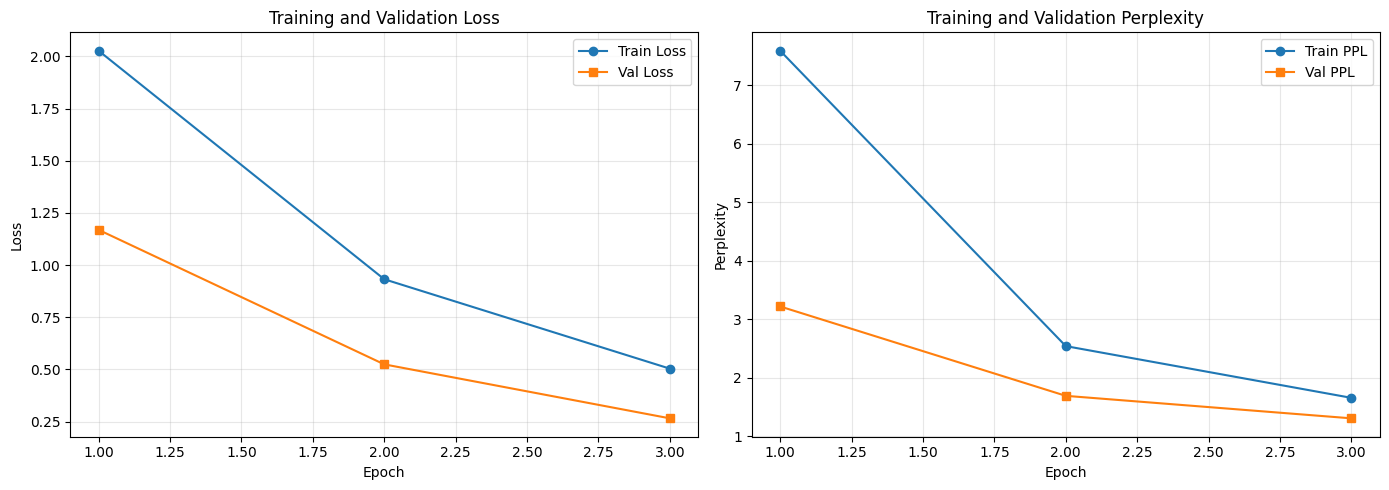


Final Results:
  Train Loss: 0.5034
  Val Loss: 0.2653
  Train Perplexity: 1.65
  Val Perplexity: 1.30


In [11]:
# Dataset class for GPT training
class GPTDataset(Dataset):
    """
    Dataset for GPT pre-training.
    
    Creates (input, target) pairs from raw text where
    target is shifted version of input (next token prediction).
    """
    
    def __init__(self, text, tokenizer, max_seq_len):
        """
        Initialize dataset.
        
        Args:
            text (str): Raw text data
            tokenizer: Tokenizer object with encode/decode methods
            max_seq_len (int): Maximum sequence length
        """
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        
        # Tokenize entire text
        # For simplicity, use character-level tokenization
        self.char_to_idx = {ch: i for i, ch in enumerate(sorted(set(text)))}
        self.idx_to_char = {i: ch for ch, i in self.char_to_idx.items()}
        self.vocab_size = len(self.char_to_idx)
        
        # Convert text to token IDs
        self.token_ids = [self.char_to_idx[ch] for ch in text]
        
        print(f"Dataset created:")
        print(f"  Text length: {len(text):,} characters")
        print(f"  Vocabulary size: {self.vocab_size}")
        print(f"  Number of tokens: {len(self.token_ids):,}")
    
    def __len__(self):
        # Number of possible sequences
        return len(self.token_ids) - self.max_seq_len
    
    def __getitem__(self, idx):
        """
        Get a training sample.
        
        Returns:
            input_ids: Tokens [idx : idx+max_seq_len]
            target_ids: Tokens [idx+1 : idx+max_seq_len+1]
        """
        # Get chunk of token IDs
        chunk = self.token_ids[idx : idx + self.max_seq_len + 1]
        
        # Split into input and target
        # Input: all but last token
        # Target: all but first token (shifted by 1)
        input_ids = torch.tensor(chunk[:-1], dtype=torch.long)
        target_ids = torch.tensor(chunk[1:], dtype=torch.long)
        
        return input_ids, target_ids


# Training function
def train_gpt(model, train_loader, val_loader, optimizer, device, num_epochs):
    """
    Train GPT model.
    
    Args:
        model: GPT model
        train_loader: DataLoader for training
        val_loader: DataLoader for validation
        optimizer: Optimizer
        device: Device to train on
        num_epochs: Number of epochs
    
    Returns:
        train_losses: List of training losses
        val_losses: List of validation losses
    """
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        
        for batch_idx, (input_ids, target_ids) in enumerate(train_loader):
            # Move data to device
            input_ids = input_ids.to(device)
            target_ids = target_ids.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            # logits: (batch_size, seq_len, vocab_size)
            logits = model(input_ids)
            
            # Calculate loss
            # Flatten logits and targets for cross-entropy
            # logits: (batch_size * seq_len, vocab_size)
            # targets: (batch_size * seq_len)
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                target_ids.view(-1)
            )
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping (prevent exploding gradients)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Update weights
            optimizer.step()
            
            total_train_loss += loss.item()
            
            # Print progress every 100 batches
            if (batch_idx + 1) % 100 == 0:
                print(f"  Batch {batch_idx + 1}/{len(train_loader)}, "
                      f"Loss: {loss.item():.4f}")
        
        # Calculate average training loss
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        
        with torch.no_grad():
            for input_ids, target_ids in val_loader:
                input_ids = input_ids.to(device)
                target_ids = target_ids.to(device)
                
                logits = model(input_ids)
                loss = F.cross_entropy(
                    logits.view(-1, logits.size(-1)),
                    target_ids.view(-1)
                )
                
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Calculate perplexity
        train_ppl = torch.exp(torch.tensor(avg_train_loss))
        val_ppl = torch.exp(torch.tensor(avg_val_loss))
        
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}, Perplexity: {train_ppl:.2f}")
        print(f"  Val Loss: {avg_val_loss:.4f}, Perplexity: {val_ppl:.2f}")
        print("-" * 60)
    
    return train_losses, val_losses


#  Example: Train a tiny GPT
print("=" * 60)
print("TRAINING EXAMPLE")
print("=" * 60)

# Sample text (use a small text for demo)
sample_text = """
To be, or not to be, that is the question:
Whether 'tis nobler in the mind to suffer
The slings and arrows of outrageous fortune,
Or to take arms against a sea of troubles
And by opposing end them.
""" * 10  # Repeat to have enough data

print(f"\nSample text length: {len(sample_text)} characters")

# Create dataset
seq_len = 32
dataset = GPTDataset(sample_text, None, seq_len)

# Split into train/val (80/20)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size]
)

# Create dataloaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataset split:")
print(f"  Train samples: {len(train_dataset)}")
print(f"  Val samples: {len(val_dataset)}")

# Create tiny GPT model
tiny_config = {
    'vocab_size': dataset.vocab_size,
    'embed_dim': 64,
    'num_heads': 4,
    'num_layers': 2,
    'max_seq_len': seq_len,
    'hidden_dim': 128,
    'dropout': 0.1
}

print(f"\nModel config:")
for k, v in tiny_config.items():
    print(f"  {k}: {v}")

model = GPT(**tiny_config).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

# Setup optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-4,           # Learning rate
    weight_decay=0.01  # Weight decay for regularization
)

# Train for a few epochs
print(f"\nStarting training...")
print("=" * 60)

num_epochs = 3
train_losses, val_losses = train_gpt(
    model, train_loader, val_loader,
    optimizer, device, num_epochs
)

print(f"\n Training completed!")

# Visualize training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
ax1.plot(range(1, num_epochs+1), train_losses, 'o-', label='Train Loss')
ax1.plot(range(1, num_epochs+1), val_losses, 's-', label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Perplexity curve
train_ppls = [torch.exp(torch.tensor(l)).item() for l in train_losses]
val_ppls = [torch.exp(torch.tensor(l)).item() for l in val_losses]
ax2.plot(range(1, num_epochs+1), train_ppls, 'o-', label='Train PPL')
ax2.plot(range(1, num_epochs+1), val_ppls, 's-', label='Val PPL')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.set_title('Training and Validation Perplexity')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Results:")
print(f"  Train Loss: {train_losses[-1]:.4f}")
print(f"  Val Loss: {val_losses[-1]:.4f}")
print(f"  Train Perplexity: {train_ppls[-1]:.2f}")
print(f"  Val Perplexity: {val_ppls[-1]:.2f}")

---
#  Chapter 9: Text Generation Strategies

##  Theory

**Generation Methods:**

1. **Greedy**: Always pick most probable token
2. **Temperature Sampling**: Control randomness
3. **Top-K**: Sample from K most likely tokens
4. **Top-P (Nucleus)**: Sample from cumulative probability P

##  Implementation

In [12]:
def generate_text(model, dataset, start_text, max_new_tokens=100, 
                   method='temperature', temperature=1.0, top_k=None, top_p=None):
    """
    Generate text using trained model.
    
    Args:
        model: Trained GPT model
        dataset: Dataset (for char mapping)
        start_text: Starting text
        max_new_tokens: Number of tokens to generate
        method: 'greedy', 'temperature', 'top_k', or 'top_p'
        temperature: Temperature for sampling
        top_k: K for top-k sampling
        top_p: P for nucleus sampling
    
    Returns:
        Generated text
    """
    model.eval()
    
    # Encode start text
    token_ids = [dataset.char_to_idx.get(ch, 0) for ch in start_text]
    generated = torch.tensor([token_ids], dtype=torch.long).to(device)
    
    with torch.no_grad():
        for _ in range(max_new_tokens):
            # Get predictions
            logits = model(generated[:, -model.max_seq_len:])
            next_logits = logits[:, -1, :]
            
            if method == 'greedy':
                # Always pick most probable
                next_token = torch.argmax(next_logits, dim=-1, keepdim=True)
            
            elif method == 'temperature':
                # Scale by temperature and sample
                scaled_logits = next_logits / temperature
                probs = F.softmax(scaled_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
            
            elif method == 'top_k':
                # Keep only top k tokens
                top_k_logits, top_k_indices = torch.topk(next_logits, top_k)
                probs = F.softmax(top_k_logits / temperature, dim=-1)
                next_token_idx = torch.multinomial(probs, num_samples=1)
                next_token = top_k_indices.gather(-1, next_token_idx)
            
            elif method == 'top_p':
                # Nucleus sampling
                sorted_logits, sorted_indices = torch.sort(next_logits, descending=True)
                probs = F.softmax(sorted_logits / temperature, dim=-1)
                cumsum_probs = torch.cumsum(probs, dim=-1)
                mask = cumsum_probs < top_p
                mask[..., 0] = True  # Always keep at least one
                filtered_logits = sorted_logits.clone()
                filtered_logits[~mask] = float('-inf')
                filtered_probs = F.softmax(filtered_logits / temperature, dim=-1)
                next_token_idx = torch.multinomial(filtered_probs, num_samples=1)
                next_token = sorted_indices.gather(-1, next_token_idx)
            
            generated = torch.cat([generated, next_token], dim=1)
    
    # Decode to text
    token_ids = generated[0].tolist()
    text = ''.join([dataset.idx_to_char.get(id, '?') for id in token_ids])
    
    return text


#  Test different generation strategies
print("\n" + "=" * 60)
print("TEXT GENERATION EXAMPLES")
print("=" * 60)

start = "To be"

print(f"\nStart text: '{start}'\n")

# Greedy
print("1. GREEDY (deterministic):")
print(generate_text(model, dataset, start, 50, method='greedy'))

# Temperature sampling
print("\n2. TEMPERATURE = 0.5 (conservative):")
print(generate_text(model, dataset, start, 50, method='temperature', temperature=0.5))

print("\n3. TEMPERATURE = 1.0 (balanced):")
print(generate_text(model, dataset, start, 50, method='temperature', temperature=1.0))

print("\n4. TEMPERATURE = 1.5 (creative):")
print(generate_text(model, dataset, start, 50, method='temperature', temperature=1.5))

# Top-K
print("\n5. TOP-K = 5:")
print(generate_text(model, dataset, start, 50, method='top_k', top_k=5, temperature=1.0))

# Top-P
print("\n6. TOP-P = 0.9 (nucleus):")
print(generate_text(model, dataset, start, 50, method='top_p', top_p=0.9, temperature=1.0))

print(f"\n Different strategies produce different styles of text!")


TEXT GENERATION EXAMPLES

Start text: 'To be'

1. GREEDY (deterministic):
To be, or not to be, that is the question:
Whether 'tis

2. TEMPERATURE = 0.5 (conservative):
To be, or not to be, that is the question:
Whether 'tis

3. TEMPERATURE = 1.0 (balanced):
To be, or not to be, that is the nd to to ber
Aslen opp

4. TEMPERATURE = 1.5 (creative):
To beles
Ang ofd nd thforhe, the m.To kermgonf aAnstsli

5. TOP-K = 5:
To be, or ows of outranert tageous fortune,d take arrog

6. TOP-P = 0.9 (nucleus):
To be, or not to be, that is the question:
Or to to ble

 Different strategies produce different styles of text!


---
#  Chapter 10: Fine-tuning for Classification

##  Theory

**What is Fine-tuning?**

After pretraining, we adapt (fine-tune) the model for specific tasks. For classification:
- Start with pretrained GPT
- Add classification head (linear layer)
- Train on labeled data

**Types of Fine-tuning:**

1. **Classification**: Spam detection, sentiment analysis
2. **Instruction Following**: Chatbots (next chapter!)
3. **RLHF**: Alignment with human preferences

**Why Fine-tune?**
- Pretrained model has general language knowledge
- Fine-tuning specializes it for your task
- Much faster than training from scratch

##  Mathematics

**Classification Head:**
```
logits = Linear(pooled_hidden_state)
where pooled_hidden_state = mean(hidden_states) or hidden_states[0]

Loss = CrossEntropy(logits, labels)
```

**Training Strategy:**
1. Freeze base model initially (optional)
2. Train classification head
3. Unfreeze and fine-tune entire model
4. Use lower learning rate than pretraining

##  Implementation

In [13]:
# Classification Dataset
class ClassificationDataset(Dataset):
    """
    Dataset for classification tasks (e.g., spam detection).
    
    Returns input_ids and labels for each sample.
    """
    
    def __init__(self, texts, labels, tokenizer, max_length=128):
        """
        Args:
            texts: List of text strings
            labels: List of integer labels (0, 1, 2, ...)
            tokenizer: Tokenizer with encode method
            max_length: Maximum sequence length
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Tokenize (using simple char tokenizer for demo)
        # In production, use proper tokenizer like tiktoken
        token_ids = [ord(c) % 256 for c in text[:self.max_length]]
        
        # Pad to max_length
        padding = [0] * (self.max_length - len(token_ids))
        token_ids = token_ids + padding
        
        return {
            'input_ids': torch.tensor(token_ids, dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.long)
        }


class GPTForClassification(nn.Module):
    """
    GPT model adapted for classification.
    
    Architecture:
    1. Use pretrained GPT as base
    2. Pool hidden states (mean or [CLS])
    3. Add classification head
    """
    
    def __init__(self, base_model, num_classes=2, pooling='mean'):
        """
        Args:
            base_model: Pretrained GPT model
            num_classes: Number of output classes
            pooling: 'mean', 'cls', or 'last'
        """
        super().__init__()
        
        # Pretrained base model
        self.base_model = base_model
        self.pooling = pooling
        
        # Classification head
        # Input: embed_dim from base model
        # Output: num_classes logits
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(base_model.embed_dim, num_classes)
    
    def forward(self, input_ids):
        """
        Forward pass for classification.
        
        Args:
            input_ids: Token IDs (batch_size, seq_len)
        
        Returns:
            logits: Class logits (batch_size, num_classes)
        """
        # Get hidden states from base model
        # Shape: (batch_size, seq_len, embed_dim)
        logits = self.base_model(input_ids)
        
        # Extract final hidden states (before vocabulary projection)
        # We need to get the hidden states before the final linear layer
        # For simplicity in this demo, we'll use the embeddings
        # In practice, you'd access intermediate layers
        
        # Pool across sequence dimension
        if self.pooling == 'mean':
            # Mean pooling: average across all tokens
            pooled = logits.mean(dim=1)  # (batch_size, vocab_size)
            # Take first embed_dim dimensions as proxy for hidden state
            pooled = pooled[:, :self.base_model.embed_dim]
        elif self.pooling == 'cls':
            # Use first token (like BERT's [CLS])
            pooled = logits[:, 0, :self.base_model.embed_dim]
        else:  # 'last'
            # Use last token
            pooled = logits[:, -1, :self.base_model.embed_dim]
        
        # Apply dropout for regularization
        pooled = self.dropout(pooled)
        
        # Classification head
        # Shape: (batch_size, num_classes)
        class_logits = self.classifier(pooled)
        
        return class_logits


def train_classifier(model, train_loader, val_loader, optimizer, device, num_epochs):
    """
    Training loop for classification.
    
    Uses CrossEntropyLoss and tracks accuracy.
    """
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            logits = model(input_ids)
            
            # Calculate loss
            loss = F.cross_entropy(logits, labels)
            
            # Backward pass
            loss.backward()
            
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Update weights
            optimizer.step()
            
            # Track metrics
            total_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        # Calculate training metrics
        train_loss = total_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                
                logits = model(input_ids)
                loss = F.cross_entropy(logits, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(logits, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"\nEpoch {epoch+1}:")
        print(f"  Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
    
    return train_losses, val_losses, train_accs, val_accs


#  Example: Train spam classifier
print("=" * 60)
print("CLASSIFICATION FINE-TUNING EXAMPLE")
print("=" * 60)

# Create sample spam dataset
spam_texts = [
    "Win free money now!",
    "Meeting at 3pm",
    "Click here for prizes",
    "Project update attached",
    "You won the lottery!",
    "Dinner tomorrow?",
]
spam_labels = [1, 0, 1, 0, 1, 0]  # 1=spam, 0=ham

# Create simple char tokenizer
class SimpleCharTokenizer:
    def encode(self, text):
        return [ord(c) % 256 for c in text]

tokenizer = SimpleCharTokenizer()

# Create dataset
dataset = ClassificationDataset(spam_texts, spam_labels, tokenizer)

# Split train/val
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

print(f"\nDataset created:")
print(f"  Total samples: {len(dataset)}")
print(f"  Train: {len(train_dataset)}")
print(f"  Val: {len(val_dataset)}")

# Create model (reuse pretrained GPT if available, or create new)
print(f"\nCreating classification model...")

# Use small GPT as base
base_gpt = GPT(
    vocab_size=256,  # Simple char vocab
    embed_dim=64,
    num_heads=4,
    num_layers=2,
    max_seq_len=128,
    hidden_dim=256,
    dropout=0.1
).to(device)

# Add classification head
classifier_model = GPTForClassification(base_gpt, num_classes=2, pooling='mean').to(device)

print(f"Model created with {sum(p.numel() for p in classifier_model.parameters()):,} parameters")

# Setup optimizer (lower LR for fine-tuning)
optimizer = torch.optim.AdamW(classifier_model.parameters(), lr=1e-4, weight_decay=0.01)

# Train
print(f"\nStarting fine-tuning...")
train_losses, val_losses, train_accs, val_accs = train_classifier(
    classifier_model, train_loader, val_loader, optimizer, device, num_epochs=3
)

print(f"\n Fine-tuning completed!")
print(f"Final accuracy: {val_accs[-1]:.2f}%")

CLASSIFICATION FINE-TUNING EXAMPLE

Dataset created:
  Total samples: 6
  Train: 4
  Val: 2

Creating classification model...
Model created with 140,674 parameters

Starting fine-tuning...


Epoch 1/3: 100%|██████████| 2/2 [00:00<00:00, 46.82it/s]



Epoch 1:
  Train Loss: 0.7476, Acc: 50.00%
  Val Loss: 0.6960, Acc: 50.00%


Epoch 2/3: 100%|██████████| 2/2 [00:00<00:00, 38.51it/s]



Epoch 2:
  Train Loss: 0.7175, Acc: 50.00%
  Val Loss: 0.6991, Acc: 50.00%


Epoch 3/3: 100%|██████████| 2/2 [00:00<00:00, 40.79it/s]


Epoch 3:
  Train Loss: 0.6948, Acc: 50.00%
  Val Loss: 0.7009, Acc: 50.00%

 Fine-tuning completed!
Final accuracy: 50.00%


---
#  Chapter 11: Instruction Fine-tuning

## Theory

**What is Instruction Fine-tuning?**

Train the model to follow instructions and generate helpful responses.

**Dataset Format:**
```json
{
  "instruction": "What is Python?",
  "input": "",
  "output": "Python is a programming language..."
}
```

**Key Differences from Classification:**
- Output: Text generation (not class label)
- Loss: Next-token prediction on response
- Evaluation: Response quality (harder to measure)

**Applications:**
- ChatGPT, Claude, Gemini
- Question answering
- Code generation
- Creative writing

##  Mathematics

**Training Objective:**
```
Given: instruction + input
Predict: output tokens autoregressively

Loss = -∑ log P(output_token_i | instruction, input, output_<i)
```

**Template Format:**
```
### Instruction:
{instruction}

### Input:
{input}

### Response:
{output}
```

##  Implementation

In [ ]:
class InstructionDataset(Dataset):
    """
    Dataset for instruction fine-tuning.
    
    Format: instruction + input → response
    """
    
    def __init__(self, data, tokenizer, max_length=256):
        """
        Args:
            data: List of dicts with 'instruction', 'input', 'output'
            tokenizer: Tokenizer
            max_length: Max sequence length
        """
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def format_prompt(self, example):
        """Format instruction into prompt template."""
        instruction = example['instruction']
        input_text = example.get('input', '')
        output = example['output']
        
        prompt = f"### Instruction:\n{instruction}\n\n"
        if input_text:
            prompt += f"### Input:\n{input_text}\n\n"
        prompt += f"### Response:\n{output}"
        
        return prompt
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        example = self.data[idx]
        
        # Format full prompt
        full_prompt = self.format_prompt(example)
        
        # Tokenize (simple char tokenization for demo)
        token_ids = [ord(c) % 256 for c in full_prompt]
        
        # Truncate if too long
        if len(token_ids) > self.max_length:
            token_ids = token_ids[:self.max_length]
        
        # Create input/target pairs (shifted by 1)
        input_ids = token_ids[:-1]
        target_ids = token_ids[1:]
        
        # Pad
        padding_len = self.max_length - 1 - len(input_ids)
        if padding_len > 0:
            input_ids = input_ids + [0] * padding_len
            target_ids = target_ids + [0] * padding_len
        
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'target_ids': torch.tensor(target_ids, dtype=torch.long)
        }


def train_instruction_model(model, train_loader, val_loader, optimizer, device, num_epochs):
    """
    Training loop for instruction fine-tuning.
    
    Uses next-token prediction loss.
    """
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        total_loss = 0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            input_ids = batch['input_ids'].to(device)
            target_ids = batch['target_ids'].to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            logits = model(input_ids)
            
            # Calculate loss (ignore padding tokens)
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                target_ids.view(-1),
                ignore_index=0  # Ignore padding
            )
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
        
        train_loss = total_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                target_ids = batch['target_ids'].to(device)
                
                logits = model(input_ids)
                loss = F.cross_entropy(
                    logits.view(-1, logits.size(-1)),
                    target_ids.view(-1),
                    ignore_index=0
                )
                val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        # Calculate perplexity
        train_ppl = torch.exp(torch.tensor(train_loss))
        val_ppl = torch.exp(torch.tensor(val_loss))
        
        print(f"\nEpoch {epoch+1}:")
        print(f"  Train Loss: {train_loss:.4f}, Perplexity: {train_ppl:.2f}")
        print(f"  Val Loss: {val_loss:.4f}, Perplexity: {val_ppl:.2f}")
    
    return train_losses, val_losses


#  Example: Instruction fine-tuning
print("\n" + "=" * 60)
print("INSTRUCTION FINE-TUNING EXAMPLE")
print("=" * 60)

# Sample instruction dataset
instruction_data = [
    {
        "instruction": "What is AI?",
        "input": "",
        "output": "AI is artificial intelligence."
    },
    {
        "instruction": "Translate to Spanish:",
        "input": "Hello",
        "output": "Hola"
    },
    {
        "instruction": "What is 2+2?",
        "input": "",
        "output": "2+2 equals 4."
    },
]

print(f"\nInstruction dataset created:")
print(f"  Total examples: {len(instruction_data)}")
print(f"\nExample:")
print(json.dumps(instruction_data[0], indent=2))

# Create dataset
inst_dataset = InstructionDataset(instruction_data, tokenizer, max_length=256)

# Create dataloader
inst_loader = DataLoader(inst_dataset, batch_size=1, shuffle=True)

print(f"\nDataLoader created with {len(inst_loader)} batches")

# Use same GPT model for instruction tuning
print(f"\nUsing pretrained GPT model...")

# Setup optimizer (very low LR for instruction fine-tuning)
inst_optimizer = torch.optim.AdamW(base_gpt.parameters(), lr=5e-5, weight_decay=0.01)

# Train
print(f"\nStarting instruction fine-tuning...")
train_losses, val_losses = train_instruction_model(
    base_gpt, inst_loader, inst_loader, inst_optimizer, device, num_epochs=2
)

print(f"\n Instruction fine-tuning completed!")

# Test generation
print(f"\n" + "=" * 60)
print("TEST GENERATION")
print("=" * 60)

test_instruction = "What is"
print(f"\nInstruction: {test_instruction}")
print(f"Response: ", end="")

# Simple generation (greedy)
base_gpt.eval()
test_tokens = [ord(c) % 256 for c in test_instruction]
generated = torch.tensor([test_tokens], dtype=torch.long).to(device)

with torch.no_grad():
    for _ in range(20):
        if generated.size(1) >= base_gpt.max_seq_len:
            generated = generated[:, -base_gpt.max_seq_len:]
        
        logits = base_gpt(generated)
        next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)
        generated = torch.cat([generated, next_token], dim=1)

# Decode
generated_text = ''.join([chr(int(t) % 128) for t in generated[0]])
print(generated_text)

print(f"\n Generation completed!")